In [10]:
from glob import glob

import numpy as np
import tensorflow
from joblib import Parallel, delayed

import os
import shutil
import platform

import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, Dense, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import GlobalAveragePooling1D
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
galaxy_flux_desi = np.load("../DESI_spectra/galaxy_flux.npy")
snia_flux_desi = np.load("../DESI_spectra/snia_flux.npy")
snib_flux_desi = np.load("../DESI_spectra/snib_flux.npy")
snibc_flux_desi = np.load("../DESI_spectra/snibc_flux.npy")
snic_flux_desi = np.load("../DESI_spectra/snic_flux.npy")
sniin_flux_desi = np.load("../DESI_spectra/sniin_flux.npy")
sniilp_flux_desi = np.load("../DESI_spectra/sniilp_flux.npy")
sniip_flux_desi = np.load("../DESI_spectra/sniip_flux.npy")
kn_flux = np.load("../DESI_spectra/kn_flux.npy")

tde_flux_ztf = np.load("../ztf_spectra/tde_flux.npy")
tde_flux_paper = np.load("../tde_flux_1.npy")
snia_flux_ztf = np.load("../ztf_spectra/snia_flux.npy")
snii_flux_ztf = np.load("../ztf_spectra/snii_flux.npy")
snib_flux_ztf = np.load("../ztf_spectra/snib_flux.npy")
snic_flux_ztf = np.load("../ztf_spectra/snic_flux.npy")
galaxy_flux_ztf = np.load("../ztf_spectra/gal_flux.npy")
agn_flux = np.load("../ztf_spectra/agn_flux.npy")
nls_flux = np.load("../ztf_spectra/nls_flux.npy")
qso_flux = np.load("../ztf_spectra/qso_flux.npy")

snia_flux = np.vstack([snia_flux_desi, snia_flux_ztf])
snibc_flux = np.vstack([snib_flux_desi, snib_flux_ztf, snibc_flux_desi, snic_flux_ztf, snic_flux_desi])
snii_flux = np.vstack([sniin_flux_desi, snii_flux_ztf, sniin_flux_desi, sniilp_flux_desi, sniip_flux_desi])
galaxy_flux = np.vstack([galaxy_flux_desi, galaxy_flux_ztf, agn_flux, nls_flux, qso_flux])
tde_flux = np.vstack([tde_flux_ztf, tde_flux_paper])

minw, maxw, nbins = 3000., 8000., 150

ngalaxy, nbins  = galaxy_flux.shape
nsnia, nbins  = snia_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnii, nbins = snii_flux.shape
ntde, nbins = tde_flux.shape
nkn, nbins = kn_flux.shape
ngalaxy, nsnia, nsnibc, nsnii, ntde, nkn, nbins

x = np.concatenate([galaxy_flux, 
                    snia_flux,
                    snibc_flux,
                    snii_flux,
                    tde_flux,
                    kn_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Galaxy',
          'SN Ia',
          'SN Ib/c',
          'SN II',
          'TDE',
          'KN']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(ngalaxy, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnibc, 2),
                        np.full(nsnii, 3),
                        np.full(ntde, 4),
                        np.full(nkn, 5)
                       ]))

n_sample = [ngalaxy, nsnia, nsnibc, nsnii, ntde, nkn]
weights = np.max(n_sample) / n_sample
class_weight = {}
for i in range(len(weights)):
    class_weight[i] = weights[i]

Verifying fold 1...
664/664 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


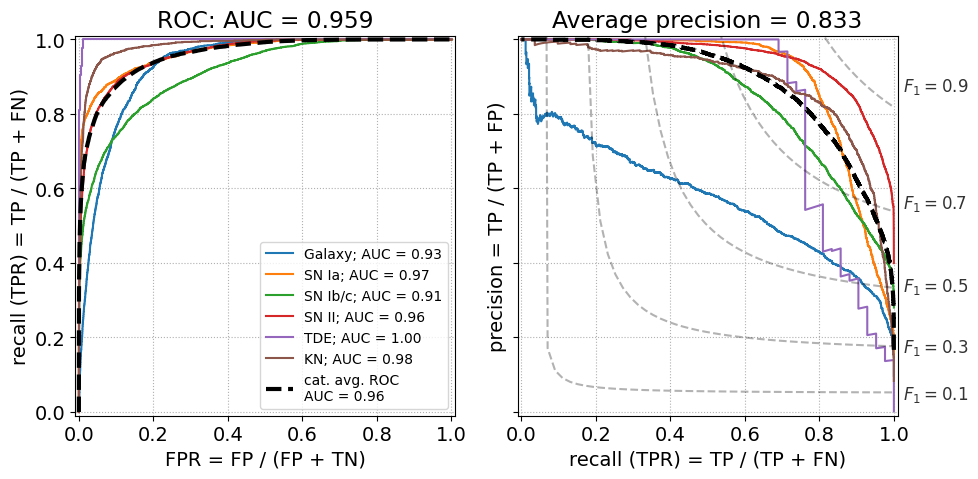

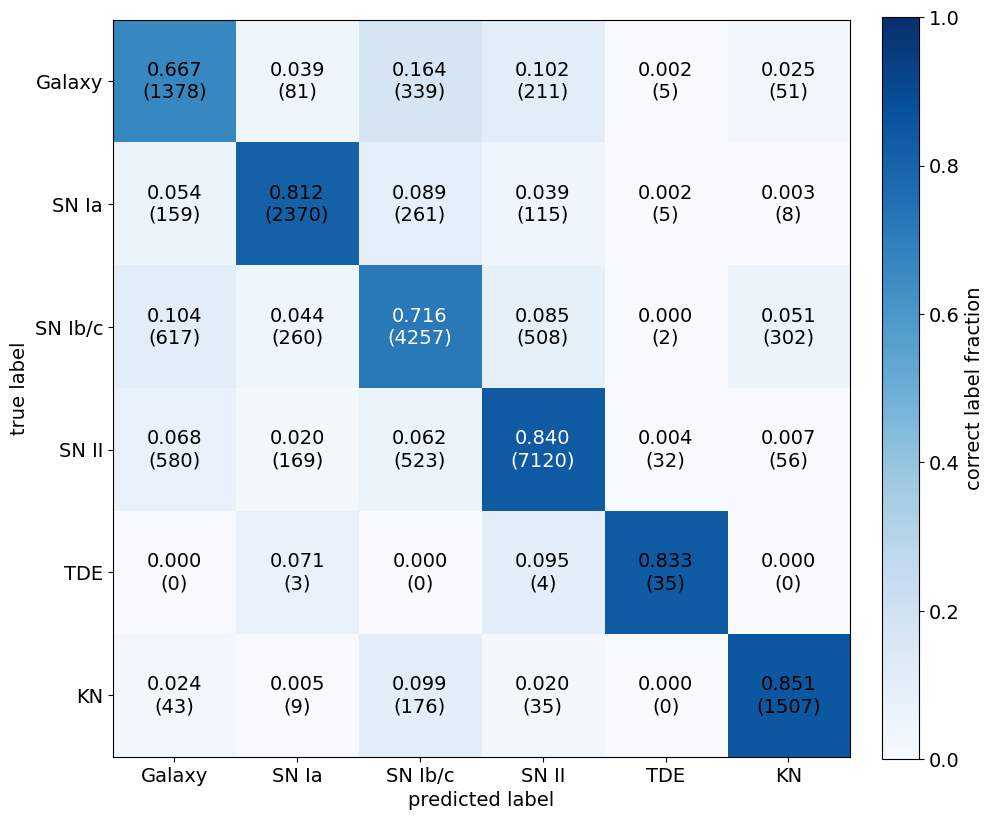

Verifying fold 2...
664/664 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


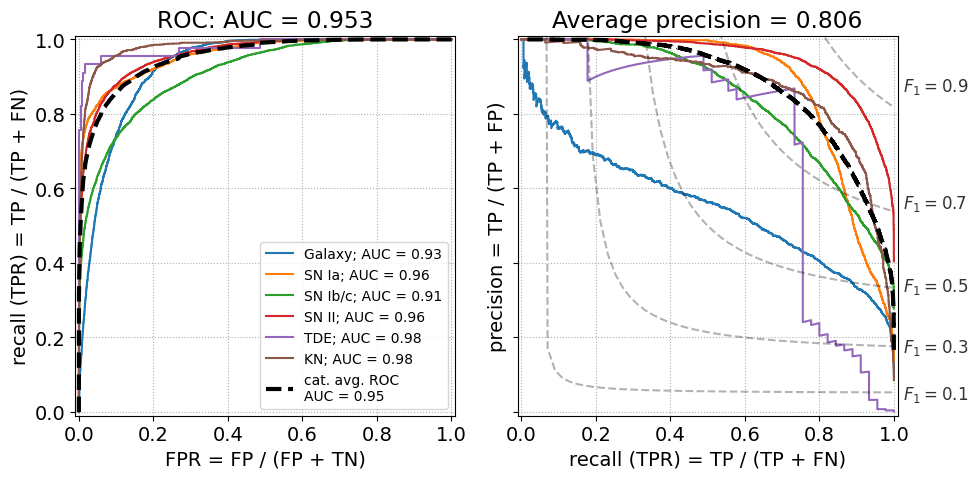

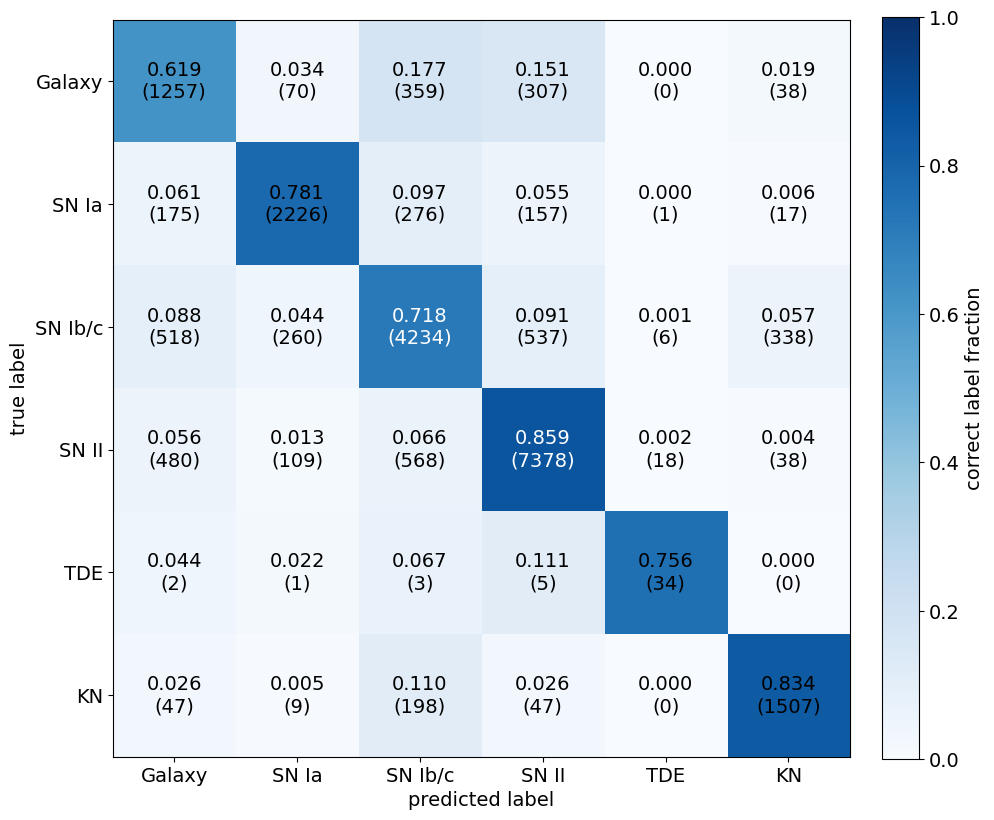

Verifying fold 3...
664/664 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


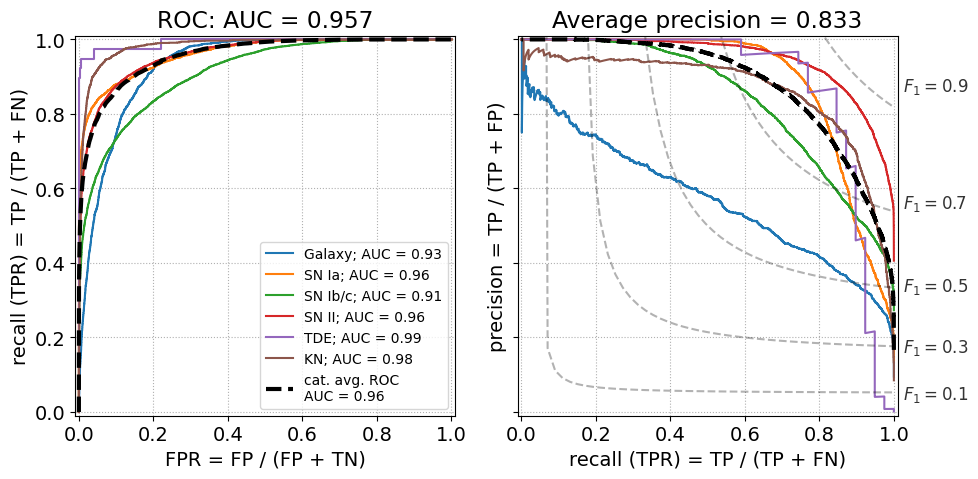

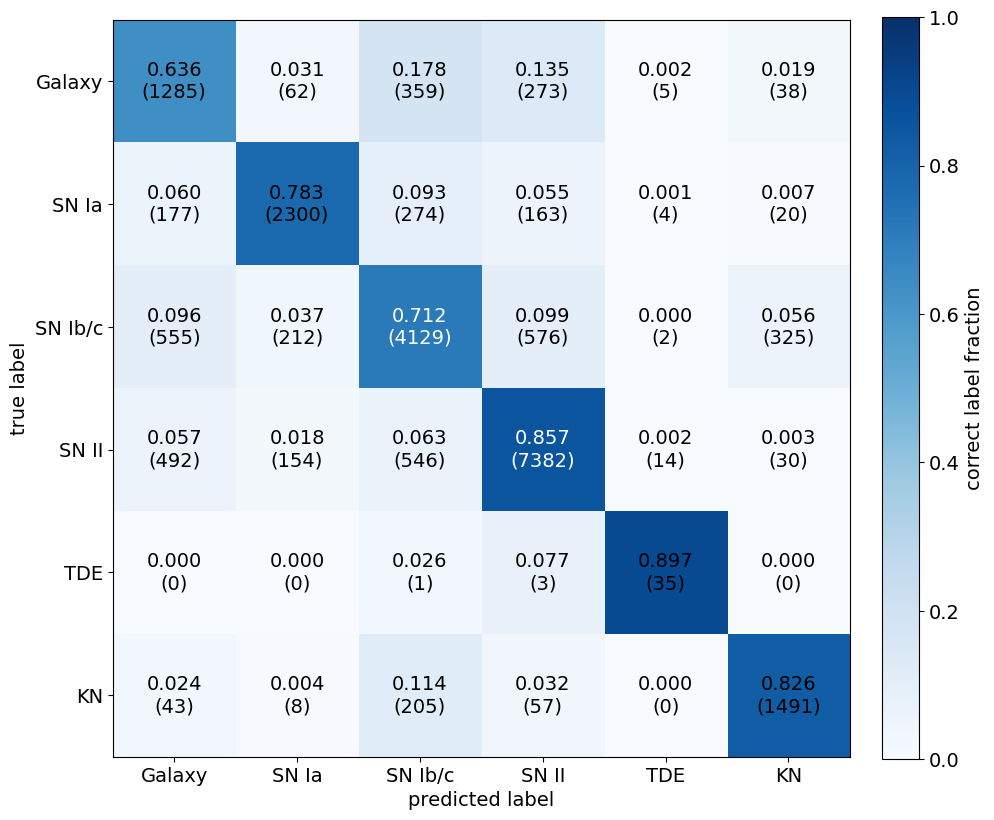

Verifying fold 4...
664/664 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


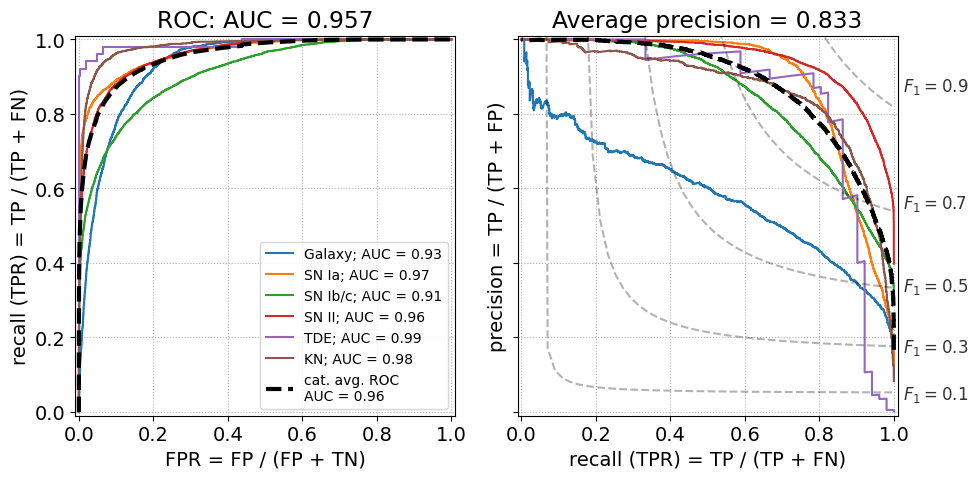

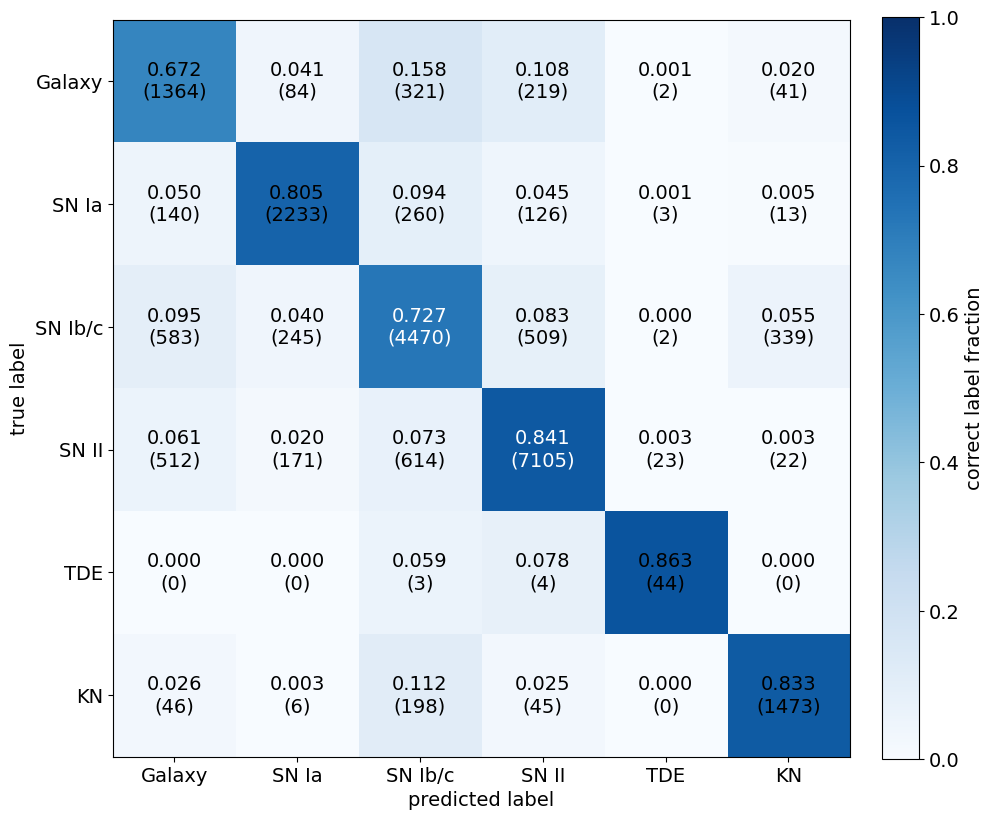

Verifying fold 5...
664/664 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


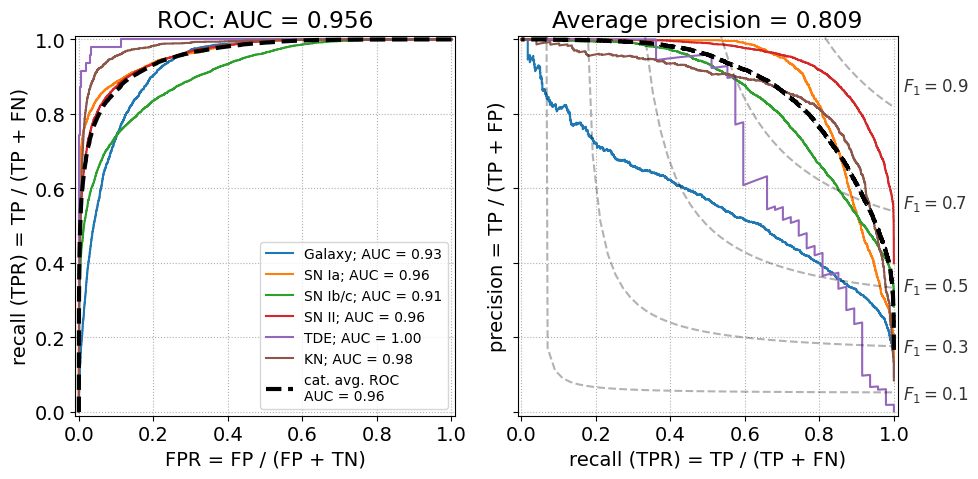

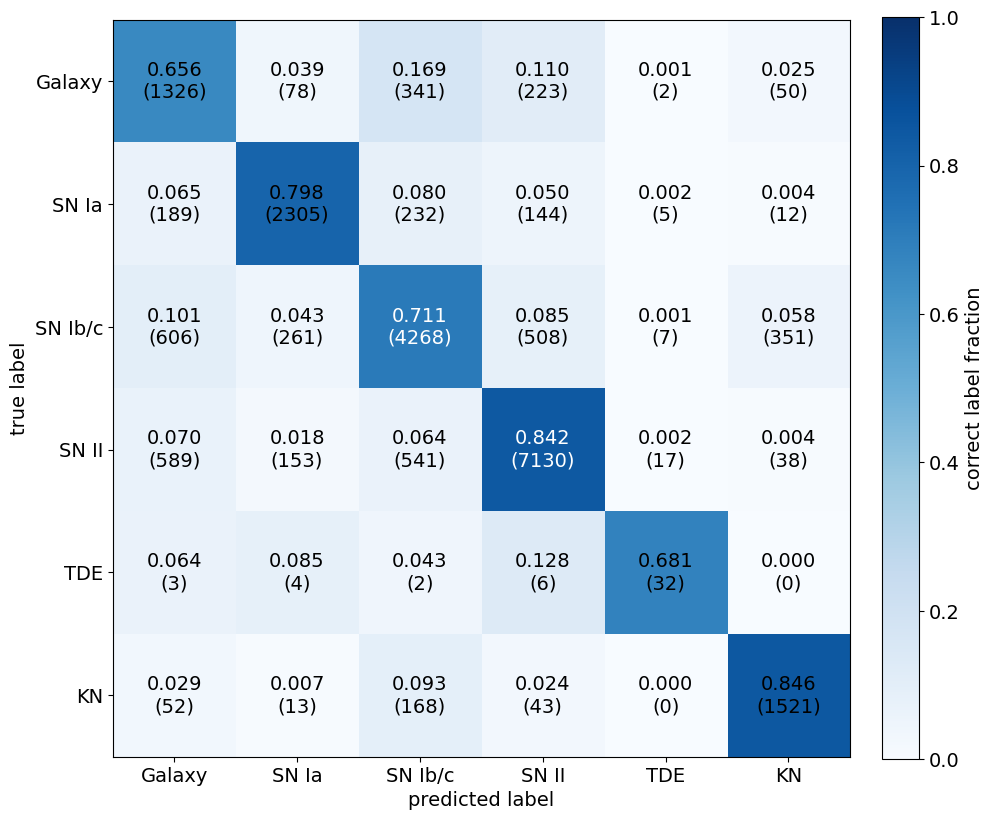

In [13]:
# Define the number of folds
num_folds = 5

batch = 30
epoch = 180

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=2)

# Prepare for tracking results
fold_no = 1

for train_index, test_index in kf.split(x, y):
    print(f"Verifying fold {fold_no}...")
    
    dropout = 0.6
    model = tf.keras.models.load_model(f'kfold_model/fold_{fold_no}_b{batch}_e{epoch}_model.keras')

    # Split the data into train and test for this fold
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    y_pred = model.predict(x_test)
    
    fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

    all_fpr = None
    all_tpr = None

    fpr = dict()
    tpr = dict()
    pre = dict()
    rec = dict()
    for i in range(ntypes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
        roc_auc = auc(fpr[i], tpr[i])

        ax = axes[0]
        ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
        ax.grid(ls=':')

        pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        ax = axes[1]
        ax.plot(rec[i], pre[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(ntypes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr / ntypes
    fpr['macro'] = np.insert(fpr['macro'], 0, 0)
    tpr['macro'] = np.insert(tpr['macro'], 0, 0)
    roc_auc_macro = auc(fpr['macro'], tpr['macro'])

    ax = axes[0]
    ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
            label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
    ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
           ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
           title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
           aspect='equal')
    ax.legend(fontsize=10, loc='lower right')

    ax = axes[1]
    pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
    ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

    f_scores = np.linspace(0.1, 0.9, num=5)
    for f_score in f_scores:
        x_ = np.linspace(0.01, 1)
        y_ = f_score * x_ / (2 * x_ - f_score)
        l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
        ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                    fontsize=12, alpha=0.8)
    ax.grid(ls=':')
    ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
           ylabel='precision = TP / (TP + FP)',
           title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
           aspect='equal')

    fig.tight_layout()
    plt.savefig('fold{}_b{}_e{}_metrics.png'.format(fold_no, batch, epoch))
    plt.show()
    
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(1,1, figsize=(10,9))

    im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
    cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label('correct label fraction')

    ax.set(aspect='equal',
           xlabel='predicted label',
           xticks=np.arange(cm.shape[1]),
           xticklabels=labels,
           ylabel='true label',
           yticks=np.arange(cm.shape[1]),
           yticklabels=labels)

    thresh = 0.5*cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                    ha='center', va='center',
                    color='black' if cm[i,j] < thresh else 'white')

    plt.tight_layout()
    plt.savefig('fold{}_b{}_e{}_matrix.png'.format(fold_no, batch, epoch))
    plt.show()
    
    fold_no += 1